In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO
from utils import clf_eval

In [2]:
def get_taxa(df: pd.DataFrame):
    # somehow this is faster than using vectorized pandas string ops
    return df['description'].map(
        #lambda x: x.split(' ', 1)[1]
        lambda x: ';'.join(x.split(' ', 1)[1].split(';')[:-1])
    )

def get_domain_grouped_mean_std(df : pd.DataFrame, mult):
    grouped = df.groupby('description')
    stats = grouped.agg(['mean', 'std'])
    stats['domain'] = stats.index.map(lambda x: x.split(';', 1)[0])
    sg = stats.groupby('domain')
    fields = ['gapped', 'primers', 'frequent']
    fstats = [sg[f].apply(lambda x: x.sort_values('mean')) for f in fields]
    m = pd.concat([x.set_axis(range(len(x)))['mean'] for x in fstats], axis=1, ignore_index=True).set_axis(fields, axis=1) * mult
    s = pd.concat([x.set_axis(range(len(x)))['std'] for x in fstats], axis=1, ignore_index=True).set_axis(fields, axis=1).fillna(0) * mult
    return m, s

def get_grouped_domain_labels(df: pd.DataFrame):
    grouped = df.groupby('description')
    stats = grouped.agg(['mean', 'std'])
    stats['domain'] = stats.index.map(lambda x: x.split(';', 1)[0])
    sg = stats.groupby('domain')
    fields = ['gapped', 'primers', 'frequent']
    fstats = [sg[f].apply(lambda x: x.sort_values('mean')) for f in fields]
    d = fstats[0].reset_index()['domain']
    return d


def make_sklearn_dataset(dfg, dfm, field):
    gt = dfg[field].values
    mut = dfm[field].values
    X = np.zeros(len(gt)*2, type(gt[0]))
    y = np.zeros(len(gt)*2, int)
    for i in range(len(gt)):
        X[i*2] = gt[i]
        y[i*2] = 1
        X[i*2+1] = mut[i]
        y[i*2+1] = 0
    return X[:,None], y

def print_pretty(r, fn, X, y):
    print('\t'.join([str(r), '{0:<25}'.format(fn)] + [str(x) if i < 4 else '{:.2f}'.format(x*100) for i, x in enumerate(clf_eval(fn, X, y))]))

In [ ]:
# load
fn_gt = './data-gt.csv'
fns_mut = ['./data-m' + s + '.csv' for s in ['0.1', '0.05', '0.01']]

dfg = pd.read_csv(fn_gt)
dfms = [pd.read_csv(fn_mut) for fn_mut in fns_mut]

In [4]:
# prepare for eval without 18S or training samples
pd.options.mode.copy_on_write = True

# drop 18S
dfg_no18s = dfg[~dfg['description'].map(lambda x: 'Eukaryota;' in x)]
dfms_no18s = [dfm[~dfm['description'].map(lambda x: 'Eukaryota;' in x)] for dfm in dfms]

# load ids from training set
trainf = './SILVA_138.2_SSURef_NR99_tax_silva_filtered.fasta'
train_ids = []
for e in SeqIO.parse(trainf, 'fasta'):
    train_ids.append(e.id)

# drop ids from training set
def drop_train(df):
    df['id'] = df['description'].apply(lambda x: x.split(' ')[0])
    return df[~df['id'].isin(train_ids)]

dfg_no18s = drop_train(dfg_no18s)
dfms_no18s = [drop_train(dfm) for dfm in dfms_no18s]

In [5]:
# compute % archaea
100 * sum(dfg_no18s['description'].map(lambda x: 'Archaea;' in x)) / len(dfg_no18s)

3.084060657261608

In [6]:
# run eval
rs = [0.1, 0.05, 0.01]

for i, r in enumerate(rs):
    clf_suf = '-' + str(r) + '.pkl'

    # LR
    Xs = []
    for feat, clf_pref in zip(['primers', 'frequent', 'gapped'], ['primer-LR', 'biomarker-LR', 'gapped-sum-LR']):
        X, y = make_sklearn_dataset(dfg_no18s, dfms_no18s[i], feat)
        fn = clf_pref + clf_suf
        print_pretty(r, fn, X, y)
        Xs.append(X)

    Xs = [Xs[-1], Xs[0], Xs[1]]

    # consensus
    X = np.concat(Xs, axis=1)
    for pre_suf in ['-max3', '-max5', '-max10', '']:
        fn = 'consensus' + pre_suf + clf_suf
        print_pretty(r, fn, X, y)

0.1	primer-LR-0.1.pkl        	1745189	24426	128756	1640859	92.72	98.62
0.1	biomarker-LR-0.1.pkl     	1756973	12642	92163	1677452	94.79	99.29
0.1	gapped-sum-LR-0.1.pkl    	1696252	73363	116073	1653542	93.44	95.85
0.1	consensus-max3-0.1.pkl   	1763267	6348	57742	1711873	96.74	99.64
0.1	consensus-max5-0.1.pkl   	1757528	12087	27013	1742602	98.47	99.32
0.1	consensus-max10-0.1.pkl  	1755308	14307	18645	1750970	98.95	99.19
0.1	consensus-0.1.pkl        	1754278	15337	23879	1745736	98.65	99.13
0.05	primer-LR-0.05.pkl       	1430346	339269	128756	1640859	92.72	80.83
0.05	biomarker-LR-0.05.pkl    	1616208	153407	216130	1553485	87.79	91.33
0.05	gapped-sum-LR-0.05.pkl   	1515966	253649	352039	1417576	80.11	85.67
0.05	consensus-max3-0.05.pkl  	1729794	39821	313928	1455687	82.26	97.75
0.05	consensus-max5-0.05.pkl  	1712103	57512	246623	1522992	86.06	96.75
0.05	consensus-max10-0.05.pkl 	1695496	74119	165342	1604273	90.66	95.81
0.05	consensus-0.05.pkl       	1685469	84146	194225	1575390	89.02	95.24
0.

In [7]:
# make grouped dataframes + extract mean and stdev
dfg_t = dfg.copy()
dfg_t['description'] = get_taxa(dfg_t)
dfms_t = []
for dfm in dfms:
    d = dfm.copy()
    d['description'] = get_taxa(d)
    dfms_t.append(d)

max_vals = dfg.iloc[:,1:].max()
mult = 100 / max_vals
dfg_m, dfg_s = get_domain_grouped_mean_std(dfg_t, mult)
dfm_ms = []
dfm_ss = []
for dfm in dfms_t:
    dfm_m, dfm_s = get_domain_grouped_mean_std(dfm, mult)
    dfm_ms.append(dfm_m)
    dfm_ss.append(dfm_s)

In [8]:
# get domains, rescale index
domain = get_grouped_domain_labels(dfg_t)
doms = ['Archaea', 'Bacteria', 'Eukaryota']
dom_groups = [domain[domain == d] for d in doms]
idxs = []
for i, d in enumerate(dom_groups):
    di = d.index.values.astype(float)
    # scale to exactly [0,1]
    di -= di[0]
    di /= len(di) - 1
    # pad slightly
    di *= 0.99
    di += 0.005
    # adjust forward
    di += i
    idxs.append(di)
new_index = np.concat(idxs)

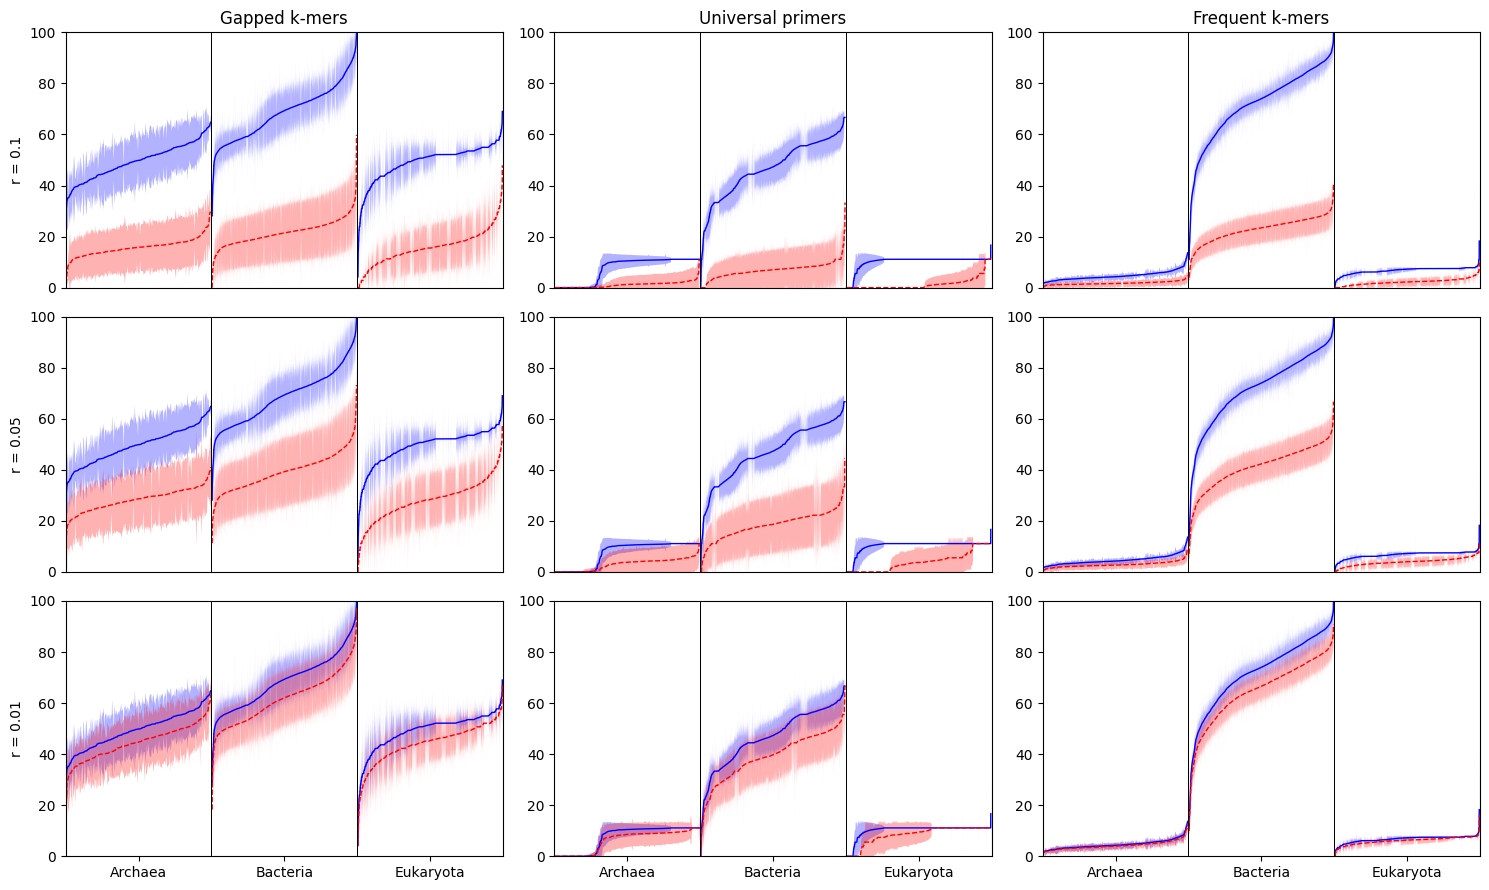

In [ ]:
# mean +/- stdev plot
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(15, 9)
fields = ['gapped', 'primers', 'frequent']
f2c = {'gapped': 'b', 'primers': 'k', 'frequent': 'r'}
f2l = {'gapped': 'Gapped k-mers', 'primers': 'Universal primers', 'frequent': 'Frequent k-mers'}
i2l = {0: '0.1', 1: '0.05', 2: '0.01'}
domain.index = new_index
for i in range(3):
    dfm_m = dfm_ms[i]
    dfm_s = dfm_ss[i]
    for j, f in enumerate(fields):
        for dfm, dfs, fmt in ((dfg_m, dfg_s, 'b-'), (dfm_m, dfm_s, 'r--')):
            # extract mean + stdev, compute upper + lower bound for fill_between
            m = dfm[f]
            s = dfs[f]
            m.index = new_index
            s.index = new_index
            ub = m + s
            lb = m - s
            
            for d in doms:
                axs[i,j].plot(m[domain == d], fmt, lw=1)
            axs[i,j].fill_between(domain.index, ub, lb, lw=0.0, aa=False, alpha=0.3, color=fmt[0])
            
            axs[i,j].set_ylim(0, 100)
            axs[i,j].set_xlim(0, 3)
            axs[i,j].set_xticks([])
            axs[i,j].vlines([1, 2], 0, 100, colors='black', lw=0.7)
            
            if i == 0: axs[i,j].set_title(f2l[f])
            elif i == 2: axs[i,j].set_xticks([0.5, 1.5, 2.5], doms)
            if j == 0: axs[i,j].set_ylabel('r = ' + i2l[i])
fig.tight_layout()
plt.savefig('out.png', dpi=300)